In [2]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecommerce-data/data.csv


In [3]:
dataset = pd.read_csv("/kaggle/input/ecommerce-data/data.csv",encoding = "ISO-8859-1")
dataset.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
dataset.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
dataset = dataset.drop(columns = "CustomerID")
dataset = dataset.dropna(subset=["Description"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540455 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    540455 non-null  object 
 1   StockCode    540455 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     540455 non-null  int64  
 4   InvoiceDate  540455 non-null  object 
 5   UnitPrice    540455 non-null  float64
 6   Country      540455 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 33.0+ MB


In [6]:
dataset["InvoiceDate"] = pd.to_datetime(dataset["InvoiceDate"])
dataset = pd.get_dummies(dataset, columns=["Country"], drop_first=True)

In [7]:
dataset["Year"] = dataset["InvoiceDate"].dt.year
dataset["Month"] = dataset["InvoiceDate"].dt.month
dataset["Day"] = dataset["InvoiceDate"].dt.day
dataset["Hour"] = dataset["InvoiceDate"].dt.hour
dataset["Weekday"] = dataset["InvoiceDate"].dt.weekday

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540455 entries, 0 to 541908
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   InvoiceNo                     540455 non-null  object        
 1   StockCode                     540455 non-null  object        
 2   Description                   540455 non-null  object        
 3   Quantity                      540455 non-null  int64         
 4   InvoiceDate                   540455 non-null  datetime64[ns]
 5   UnitPrice                     540455 non-null  float64       
 6   Country_Austria               540455 non-null  bool          
 7   Country_Bahrain               540455 non-null  bool          
 8   Country_Belgium               540455 non-null  bool          
 9   Country_Brazil                540455 non-null  bool          
 10  Country_Canada                540455 non-null  bool          
 11  Country_Channel Is

In [9]:
dataset["TotalPrice"] = dataset["Quantity"] * dataset["UnitPrice"]

In [10]:
product_sales = dataset.groupby("StockCode")["Quantity"].sum().reset_index()
product_sales.columns = ["StockCode", "TotalProductQuantity"]
dataset = dataset.merge(product_sales, on="StockCode", how="left")

invoice_total_qty = dataset.groupby("InvoiceNo")["Quantity"].sum().reset_index()
invoice_total_qty.columns = ["InvoiceNo", "TotalInvoiceQuantity"]
dataset = dataset.merge(invoice_total_qty, on="InvoiceNo", how="left")

invoice_total_price = dataset.groupby("InvoiceNo")["TotalPrice"].sum().reset_index()
invoice_total_price.columns = ["InvoiceNo", "TotalInvoicePrice"]
dataset = dataset.merge(invoice_total_price, on="InvoiceNo", how="left")

In [11]:
dataset = dataset.drop(columns=["InvoiceNo", "StockCode", "Description","InvoiceDate"])
dataset.head()

,Quantity,UnitPrice,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,Country_Czech Republic,...,Country_Unspecified,Year,Month,Day,Hour,Weekday,TotalPrice,TotalProductQuantity,TotalInvoiceQuantity,TotalInvoicePrice
0,6,2.55,False,False,False,False,False,False,False,False,...,False,2010,12,1,8,2,15.30,38830,40,139.12
1,6,3.39,False,False,False,False,False,False,False,False,...,False,2010,12,1,8,2,20.34,1911,40,139.12
2,8,2.75,False,False,False,False,False,False,False,False,...,False,2010,12,1,8,2,22.00,1460,40,139.12
3,6,3.39,False,False,False,False,False,False,False,False,...,False,2010,12,1,8,2,20.34,3309,40,139.12
4,6,3.39,False,False,False,False,False,False,False,False,...,False,2010,12,1,8,2,20.34,4698,40,139.12


In [12]:
from sklearn.model_selection import train_test_split

x = dataset.drop(columns = ["TotalInvoicePrice"])
y = dataset["TotalInvoicePrice"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2,random_state=0)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

#Liner Regression
model_linear = LinearRegression()
model_linear.fit(x_train,y_train)
y_pred_linear = model_linear.predict(x_test)

#Random Forest Regression
model_random = RandomForestRegressor(n_estimators=100,random_state = 0)
model_random.fit(x_train,y_train)
y_pred_random = model_random.predict(x_test)

#Xgboost Regression
model_xgb = XGBRegressor(n_estimators = 100,learning_rate = 0.1, random_state = 0)
model_xgb.fit(x_train,y_train)
y_pred_xgb = model_xgb.predict(x_test)

#Lgbm Regression
model_lgbm = LGBMRegressor(n_estimators = 100,learning_rate = 0.1, random_state = 0)
model_lgbm.fit(x_train,y_train)
y_pred_lgbm = model_lgbm.predict(x_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 432364, number of used features: 44
[LightGBM] [Info] Start training from score 1344.077289


Liner Regression 

R2 SCORE:  0.7421135781109267
MSE:  1333893.9527357456
MAE:  633.8489172735385
----------------------------------------


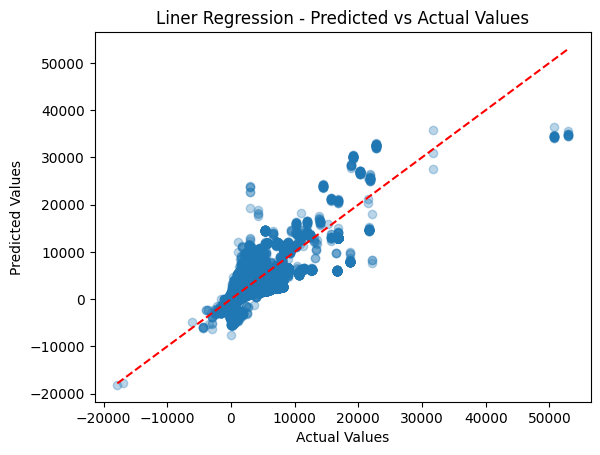

Random Forest Regression 

R2 SCORE:  0.9946926991784066
MSE:  27451.528542739175
MAE:  39.97611833701612
----------------------------------------


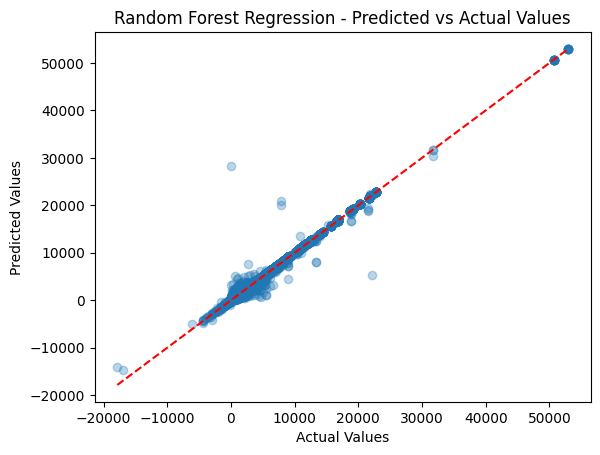

Xgboost Regression 

R2 SCORE:  0.9632032798296922
MSE:  190327.67276439012
MAE:  229.65773751846052
----------------------------------------


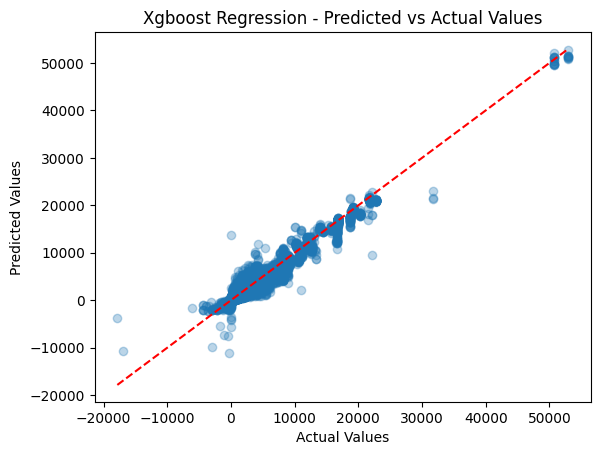

Lgbm Regression 

R2 SCORE:  0.9626333870174318
MSE:  193275.39126159978
MAE:  219.5236646158219
----------------------------------------


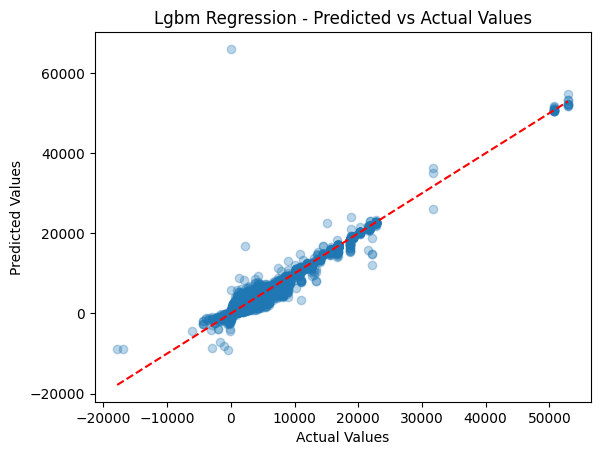

In [14]:

model_list = {
    "Liner Regression" : y_pred_linear,
    "Random Forest Regression" : y_pred_random,
    "Xgboost Regression" : y_pred_xgb,
    "Lgbm Regression" : y_pred_lgbm
}

for name, model in model_list.items():
    print(name,"\n")
    print("R2 SCORE: ",r2_score(y_test,model))
    print("MSE: ",mean_squared_error(y_test,model))
    print("MAE: ",mean_absolute_error(y_test,model))
    print("-"*40)
    
    plt.scatter(y_test, model, alpha=0.3)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} - Predicted vs Actual Values")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.show()


In [15]:
importances = model_random.feature_importances_
feature_names = x.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(importance_df)



                         Feature    Importance
46          TotalInvoiceQuantity  7.619772e-01
42                          Hour  7.916020e-02
40                         Month  5.652444e-02
41                           Day  3.113450e-02
0                       Quantity  1.903808e-02
1                      UnitPrice  1.331625e-02
43                       Weekday  1.251015e-02
44                    TotalPrice  1.217408e-02
37        Country_United Kingdom  8.278098e-03
45          TotalProductQuantity  1.529408e-03
39                          Year  1.500274e-03
25           Country_Netherlands  1.090211e-03
11                  Country_EIRE  6.394950e-04
21                 Country_Japan  2.684409e-04
15               Country_Germany  2.193013e-04
14                Country_France  1.082383e-04
8                 Country_Cyprus  1.056567e-04
34           Country_Switzerland  1.011214e-04
26                Country_Norway  6.378536e-05
33                Country_Sweden  6.018000e-05
31           

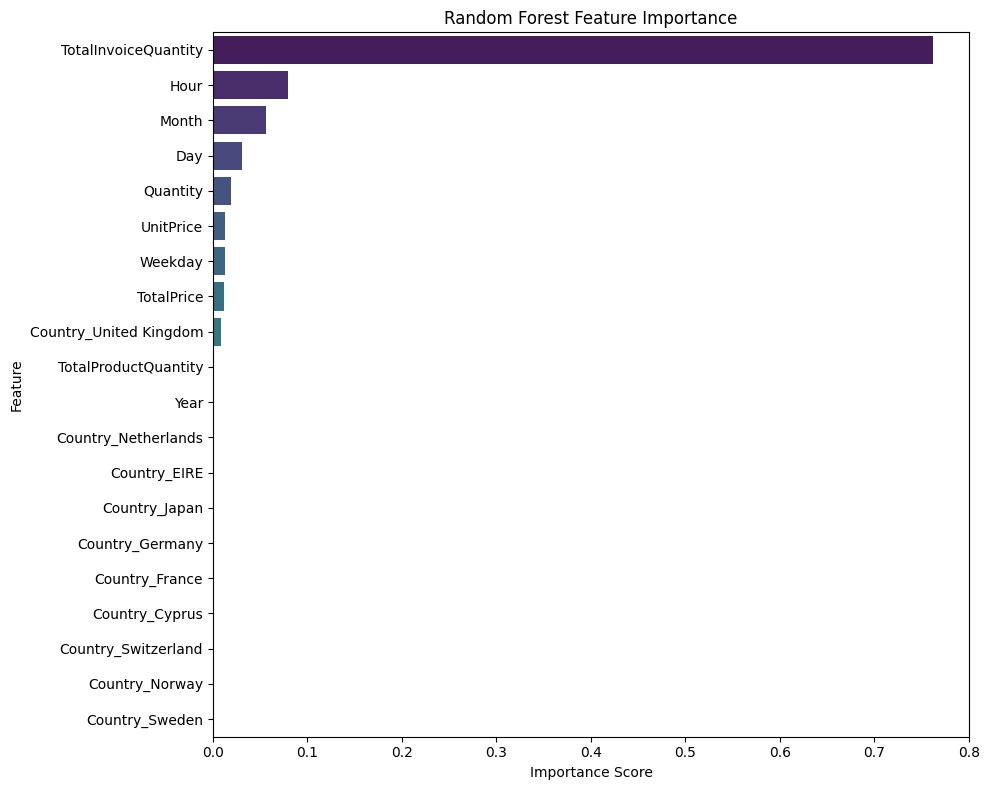

In [16]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
